In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Reshape, Input, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from tqdm import tqdm
import cv2
import csv

# Load and Process Data

In [2]:
# Paths for datasets
sentences_txt_path = "./data/metadata/sentences.txt"
sentences_folder_path = "./data/dataset"

# Load and process dataset
dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    # replace "|" with " " in label
    label = label.replace("|", " ")

    rel_path = os.path.join(sentences_folder_path, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    max_len = max(max_len, len(label))

max_text_length = max_len

csv_file_path = "data.csv"

# Write the data to the CSV file with labeled columns
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row with labeled columns
    writer.writerow(["path", "label"])
    
    # Write the data
    writer.writerows(dataset)

print("CSV file has been created successfully.")

100%|██████████| 16777/16777 [00:00<00:00, 24461.16it/s]

CSV file has been created successfully.


# Display Sample Images

In [3]:
data = pd.read_csv("./data.csv")
data.head()

,path,label
0,./data/dataset\a01-000u-s00-00.png,A MOVE to stop Mr. Gaitskell from
1,./data/dataset\a01-000u-s00-01.png,nominating any more Labour life Peers
2,./data/dataset\a01-000u-s00-02.png,is to be made at a meeting of Labour
3,./data/dataset\a01-000u-s01-01.png,put down a resolution on the subject
4,./data/dataset\a01-000u-s01-03.png,P for Manchester Exchange .


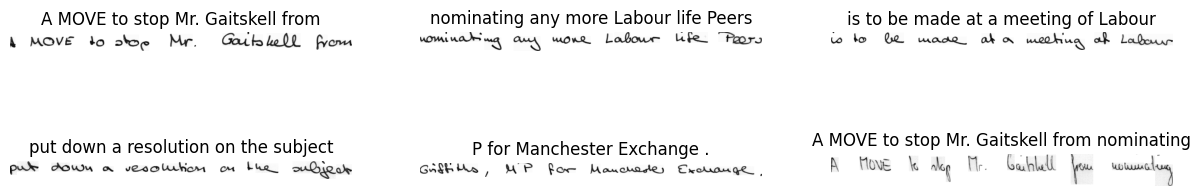

In [4]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(data.loc[i, 'label'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


# Clean Dataset

In [5]:
print("Null: ", data['label'].isnull().sum())
print("Shape: ", data.shape)

Null:  3
Shape:  (14083, 2)


In [6]:
data.dropna(axis=0, inplace=True)
data.reset_index(inplace = True, drop=True) 

In [7]:
print("Null: ", data['label'].isnull().sum())
print("Shape: ", data.shape)
print(data.head())

Null:  0
Shape:  (14080, 2)
                                 path                                  label
0  ./data/dataset\a01-000u-s00-00.png      A MOVE to stop Mr. Gaitskell from
1  ./data/dataset\a01-000u-s00-01.png  nominating any more Labour life Peers
2  ./data/dataset\a01-000u-s00-02.png   is to be made at a meeting of Labour
3  ./data/dataset\a01-000u-s01-01.png   put down a resolution on the subject
4  ./data/dataset\a01-000u-s01-03.png            P for Manchester Exchange .


In [8]:
data['label'] = data['label'].str.upper()
data.reset_index(inplace = True, drop=True)
data.head()

,path,label
0,./data/dataset\a01-000u-s00-00.png,A MOVE TO STOP MR. GAITSKELL FROM
1,./data/dataset\a01-000u-s00-01.png,NOMINATING ANY MORE LABOUR LIFE PEERS
2,./data/dataset\a01-000u-s00-02.png,IS TO BE MADE AT A MEETING OF LABOUR
3,./data/dataset\a01-000u-s01-01.png,PUT DOWN A RESOLUTION ON THE SUBJECT
4,./data/dataset\a01-000u-s01-03.png,P FOR MANCHESTER EXCHANGE .


# Data Augmentation

In [9]:
def augment_image2(image):
        
    if np.random.rand() < 0.7:
        kernel_size = tuple(np.random.randint(3, 6, 2) * 2 + 1)  
        #kernel_size = tuple(np.random.randint(3, 12, 2) * 2 + 1)  
        image = cv2.GaussianBlur(image, kernel_size, 0)

    # Random Brightness Adjustment
    if np.random.rand() < 0.7:
        brightness_factor = np.random.uniform(0.8, 1.1)
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random Contrast Adjustment
    if np.random.rand() < 0.7:
        contrast_factor = np.random.uniform(0.3, 1.3)
        image = np.clip((image - 127.5) * contrast_factor + 127.5, 0, 255).astype(np.uint8)

    # Random Saturation Adjustment
    if np.random.rand() < 0.7:
        saturation_factor = np.random.uniform(0.3, 1.3)
        hsv_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
        hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)
        # Extract the value (brightness) channel from the HSV image
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)[:, :, 2]
        
    rows, cols = image.shape
    shear_angle_x = np.random.uniform(-0.8, 0.8)  # Range for x-axis shear (-0.2 to 0.2 radians)
    shear_matrix_x = np.float32([[1, shear_angle_x, 0], [0, 1, 0]])
    sheared_image = cv2.warpAffine(image.copy(), shear_matrix_x, (cols, rows))

    return sheared_image

In [10]:
def resize_or_pad_image(image, target_height=64, target_width=512):
    image = cv2.resize(image, (target_width, target_height))
    return image

def preprocess(img):
    (h, w) = img.shape    
    final_image = resize_or_pad_image(img)
    return cv2.rotate(final_image, cv2.ROTATE_90_CLOCKWISE)

In [11]:
def preprocess1(img):
    (h, w) = img.shape    
    final_image = resize_or_pad_image(img)
    return augment_image2(final_image)

In [12]:
import cv2

# Load the image
flag=0
for i in range(1,100):
    image = cv2.imread(data.loc[i,'path'])
    image = resize_or_pad_image(image)
    image_shape = image.shape

    print("Shape of the image:", image_shape)

Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of the image: (64, 512, 3)
Shape of t

In [13]:
img_paths = ['./data/dataset/a01-000u-s00-00.png',
             './data/dataset/a01-000u-s00-01.png',
             './data/dataset/a01-000u-s00-02.png']

1
1
1


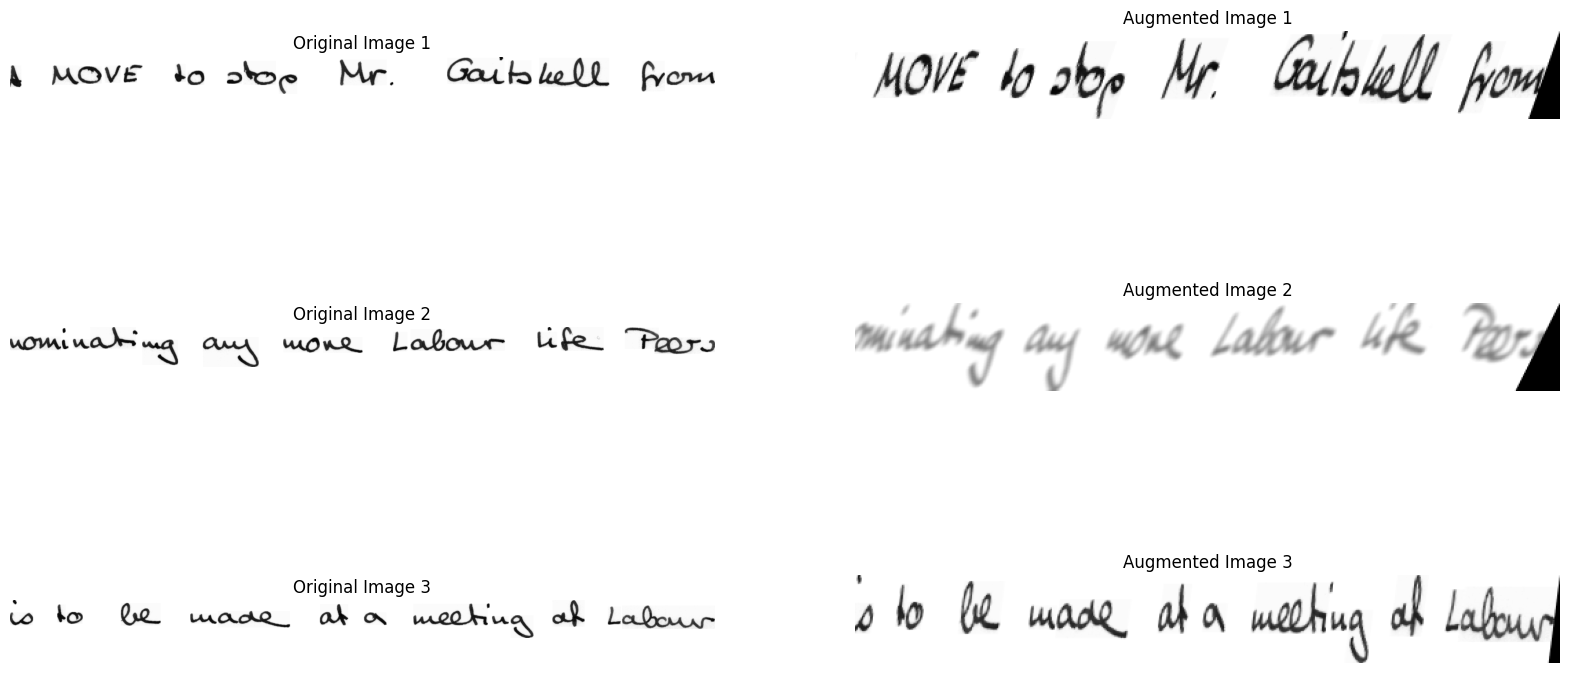

In [14]:
plt.figure(figsize=(20, 10))

for i in range(3):
    img_path = img_paths[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    aug_img = preprocess1(img)
    print(1)
    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(aug_img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.show()

# Prepare Labels

In [15]:
import numpy as np
import cv2
import random

# Set dataset sizes
train_size = 12080
valid_size = 1000
test_size = 1000

# Initialize image augmentation counter
img_aug_cnt = 0

# Initialize lists for storing images
train_x = []
valid_x = []
test_x = []

# Load and preprocess training images
for i in range(train_size):
    img_path = data.loc[i, 'path']
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Apply augmentation with a 50% probability
    if random.randint(0, 10) in [1, 2, 3, 4, 5]:
        image = augment_image2(image)
        img_aug_cnt += 1

    # Resize/pad and normalize the image
    image = preprocess(image)
    image = image / 255.0

    train_x.append(image)

# Load and preprocess validation images
for i in range(train_size, train_size + valid_size):
    img_path = data.loc[i, 'path']
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize/pad and normalize the image
    image = preprocess(image)
    image = image / 255.0

    valid_x.append(image)

# Load and preprocess test images
for i in range(train_size + valid_size, train_size + valid_size + test_size):
    img_path = data.loc[i, 'path']
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize/pad and normalize the image
    image = preprocess(image)
    image = image / 255.0

    test_x.append(image)

# Print the number of images in each set
print(f'Train: {len(train_x)}, Validation: {len(valid_x)}, Test: {len(test_x)}')

# Convert lists to numpy arrays and reshape for the model
train_x = np.array(train_x).reshape(-1, 512, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 512, 64, 1)
test_x = np.array(test_x).reshape(-1, 512, 64, 1)


Train: 12080, Validation: 1000, Test: 1000


In [16]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-,!?.' "
max_str_len = 95 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 128 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        ind=alphabets.find(ch)
        if ind != -1:
            label_num.append(ind)
        else:
            label_num.append(0)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [17]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [18]:
train_y = np.ones([train_size,max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(data.loc[i, 'label'])
    train_y[i, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label'])  
    
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(train_size,train_size+valid_size):
    valid_label_len[i-train_size] = len(data.loc[i, 'label'])
    valid_y[i-train_size, 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label']) 
    
test_y = np.ones([test_size, max_str_len]) * -1
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(train_size+valid_size,train_size+valid_size+test_size):
    test_label_len[i-(train_size+valid_size)] = len(data.loc[i, 'label'])
    test_y[i-(train_size+valid_size), 0:len(data.loc[i, 'label'])]= label_to_num(data.loc[i, 'label']) 

# Define the Model

In [19]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 pre-trained on ImageNet, excluding the top layers
mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))

# Freeze the pre-trained layers to prevent them from updating during training
mobilenet_v2.trainable = False

C:\Users\Yusna\AppData\Local\Temp\ipykernel_25892\3318005239.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 64, 3))


In [20]:
from tensorflow.keras.layers import Concatenate,Flatten,LSTM, Bidirectional

In [21]:
# crnn approach
input_data = Input(shape=(512, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.5)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)


inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.5)(inner)

# CNN to RNN
inner = Reshape(target_shape=((128, 1024)), name='reshape')(inner)
inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)

In [22]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [23]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [24]:
model_final.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 512, 64,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 512, 64,   │        320 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 64,   │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 64,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max1 (MaxPooling2D) │ (None, 256, 32,   │          0 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 256, 32,   │     18,496 │ max1[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32,   │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 32,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max2 (MaxPooling2D) │ (None, 128, 16,   │          0 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 16,   │          0 │ max2[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 128, 16,   │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4 (Conv2D)      │ (None, 128, 16,   │    147,584 │ conv3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 16,   │        512 │ conv4[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 16,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max3 (MaxPooling2D) │ (None, 128, 8,    │          0 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 8,    │          0 │ max3[0][0]        │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 1024) │          0 │ dropout_1[0][0] 

 Total params: 2,753,186 (10.50 MB)

 Trainable params: 2,752,738 (10.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
optimizer = Adam(learning_rate=0.001)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=40, batch_size=64,verbose=1)
# ,callbacks=[early_stopping]

Epoch 1/40

189/189 ━━━━━━━━━━━━━━━━━━━━ 1058s 6s/step - loss: 137.5779 - val_loss: 99.2732
Epoch 2/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 1085s 5s/step - loss: 83.7099 - val_loss: 53.9379
Epoch 3/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - loss: 59.1919 - val_loss: 39.0841
Epoch 4/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - loss: 44.6923 - val_loss: 34.9934
Epoch 5/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - loss: 37.3378 - val_loss: 30.1533
Epoch 6/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - loss: 32.5164 - val_loss: 22.1660
Epoch 7/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - loss: 28.8495 - val_loss: 19.8774
Epoch 8/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - loss: 25.5115 - val_loss: 16.9801
Epoch 9/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - loss: 23.6712 - val_loss: 16.0940
Epoch 10/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 933s 5s/step - loss: 21.8393 - val_loss: 15.4925
Epoch 11/40
189/189 ━━━━━━━━━━━━━━━━━━━━ 1049s 6s/step - loss: 19.9872 - val_loss: 14.9801
Epoch 12/40
18

In [36]:
# Function to process and predict the text from an image
def process_and_predict(image_path, model):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded properly
    if image is None:
        raise ValueError(f"Could not load image at path: {image_path}")
    
    # Preprocess the image
    preprocessed_image = preprocess(image)
    
    # Normalize the image
    preprocessed_image = preprocessed_image.astype('float32') / 255.0
    
    # Expand dimensions to match model input
    input_image = np.expand_dims(preprocessed_image, axis=-1)  # Add the channel dimension
    input_image = np.expand_dims(input_image, axis=0)  # Add the batch dimension
    
    # Transpose the dimensions to match the expected shape (None, 512, 64, 1)
    input_image = np.transpose(input_image, (0, 2, 1, 3))
    
    # Predict using the model
    prediction = model.predict(input_image)
    
    # Decode the prediction
    decoded_text = decode_predictions(np.argmax(prediction[0], axis=-1))
    
    return decoded_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


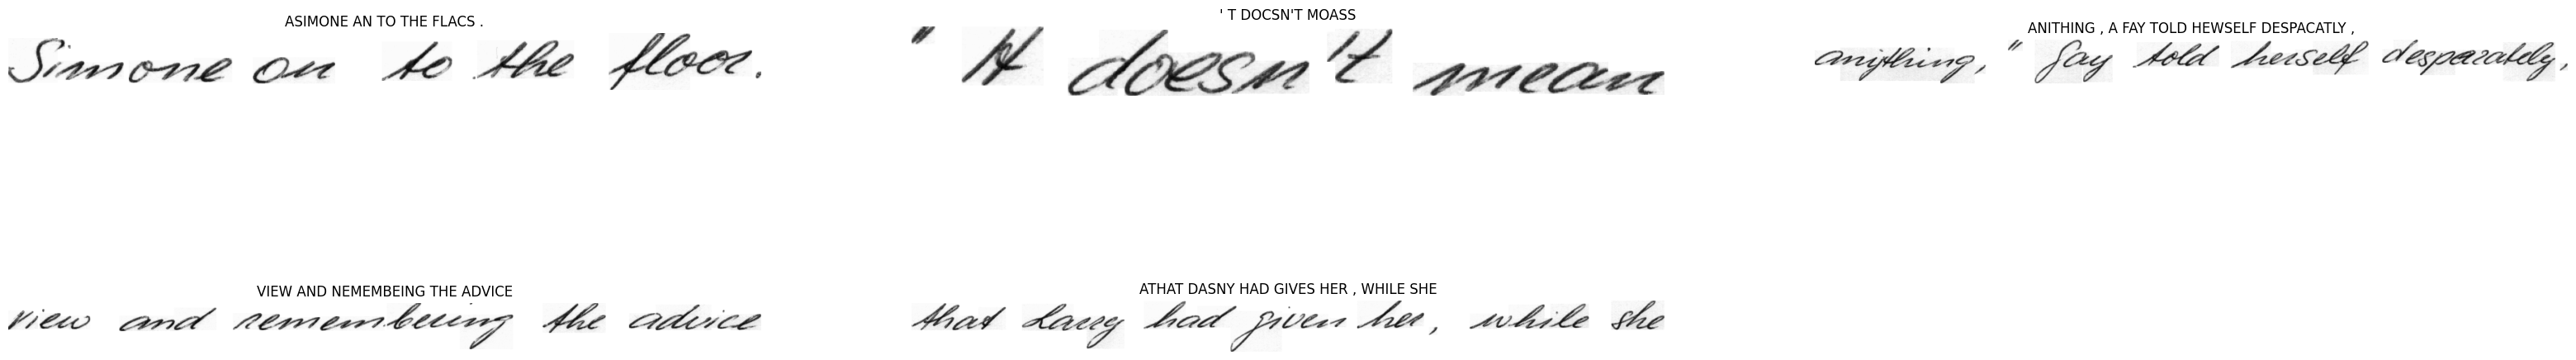

In [37]:
plt.figure(figsize=(40, 25))
for i in range(0,5):
    ax = plt.subplot(2, 3, i+1)
    img_dir = data.loc[i+train_size+valid_size, 'path']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 512, 64, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

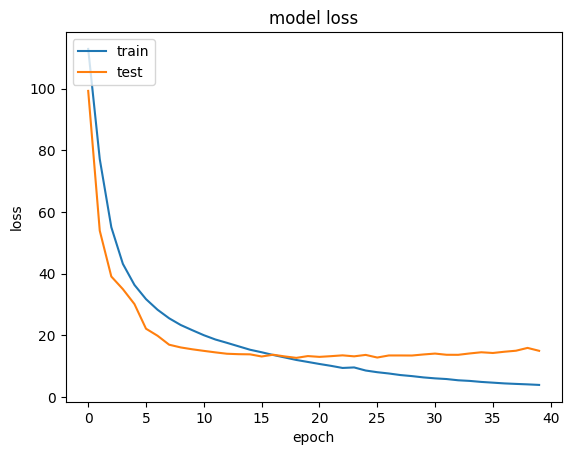

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# Load an image and predict the text
image_path = './data/dataset/a01-000u-s00-00.png'  # Replace with the actual path
predicted_text = process_and_predict(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


NameError: name 'decode_predictions' is not defined

In [42]:
print(os.getcwd())
print(os.listdir('.'))

c:\Users\Yusna\OneDrive - Institut Teknologi Sepuluh Nopember\Dokumen\Bangkit\machine-learning
['.git', '13th.ipynb', 'bismillahbisa.ipynb', 'Copy_of_OCR.ipynb', 'CosineSimilarity.ipynb', 'data', 'data.csv', 'download_fki.py', 'FirstOCRCode', 'model-ocr.ipynb', 'ocr copy.ipynb', 'OCR-model.ipynb', 'ocr.ipynb', 'ocr1.ipynb', 'README.md', 'second.ipynb', 'similarity_model.h5', 'teams_handwriting', 'word-detection.ipynb']


In [43]:
# Misalkan 'model' adalah model Anda yang sudah dilatih
import os

# Gunakan path absolut untuk menyimpan file
save_path = './ocr_model.h5'
model.save(save_path)

# Cek apakah file sudah tersimpan
if os.path.exists(save_path):
    print(f"Model saved successfully at {save_path}")
else:
    print(f"Failed to save the model at {save_path}")

Model saved successfully at ./ocr_model.h5


In [44]:
preds = model.predict(test_x)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step


In [45]:
y_true = data.loc[train_size+valid_size:train_size+valid_size+test_size, 'label']


def calculate_accuracy(y_true, y_pred):
    total_words = 0
    correct_words = 0
    total_char = 0
    correct_char = 0

    for true_sentence, pred_sentence in zip(y_true, y_pred):
        true_words = true_sentence.split()
        pred_words = pred_sentence.split()
        

        total_words += len(true_words)

        # Calculate word accuracy
        for true_word, pred_word in zip(true_words, pred_words):
            if true_word == pred_word:
                correct_words += 1

            total_char += len(true_word)
    
            for j in range(min(len(true_word), len(pred_word))):
                if true_word[j] == pred_word[j]:
                    correct_char += 1

    word_accuracy = correct_words / total_words if total_words > 0 else 0
    character_accuracy = correct_char/ total_char if total_char> 0 else 0

    return word_accuracy, character_accuracy


word_accuracy, character_accuracy = calculate_accuracy(y_true, prediction)
print("Word Accuracy:", word_accuracy)
print("Character Accuracy:", character_accuracy)

Word Accuracy: 0.5917716714741157
Character Accuracy: 0.7256377243099702


In [47]:
# Function to decode the predictions from the model
def decode_predictions(pred):
    alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-,!?.' "
    blank_char = len(alphabets)
    text = ""
    for p in pred:
        if p != blank_char:  # Ignore the blank character
            text += alphabets[p]
    return text

# Function to process and predict the text from an image
def process_and_predict(image_path, model):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded properly
    if image is None:
        raise ValueError(f"Could not load image at path: {image_path}")
    
    # Preprocess the image
    preprocessed_image = preprocess(image)
    
    # Normalize the image
    preprocessed_image = preprocessed_image.astype('float32') / 255.0
    
    # Expand dimensions to match model input
    input_image = np.expand_dims(preprocessed_image, axis=-1)  # Add the channel dimension
    input_image = np.expand_dims(input_image, axis=0)  # Add the batch dimension
    
    # Transpose the dimensions to match the expected shape (None, 512, 64, 1)
    input_image = np.transpose(input_image, (0, 2, 1, 3))
    
    # Predict using the model
    prediction = model.predict(input_image)
    
    # Decode the prediction
    decoded_text = decode_predictions(np.argmax(prediction[0], axis=-1))
    
    return decoded_text

# Load an image and predict the text
image_path = './data/dataset/a01-000u-s00-00.png'  # Replace with the actual path
predicted_text = process_and_predict(image_path, model)

print(f"Predicted Text: {predicted_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Text: A'AAAAA'     FIIRA.
